# <font color='green'> Quora Question Pairs </font>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

# 3. Exploratory Data Analysis

In [1]:
#importing all necessary modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc


from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image


import time

from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import sys
import os 
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import warnings
warnings.filterwarnings('ignore')

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
#read the data 
datafrm = pd.read_csv("train.csv")

print("Number of data points and columns:",datafrm.shape)

Number of data points and columns: (404290, 6)


In [4]:
datafrm.head(3)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0

**here our class label is is_duplicate**

In [5]:
#some information
datafrm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


in questions2 feature, there are 2 datapoints contained NULL.

We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>


- Number of duplicate(smilar) and non-duplicate(non similar) questions

In [6]:
#total no of quation pair datapoints in dataset
print("total number of datapoints:", datafrm.shape[0])

total number of datapoints: 404290


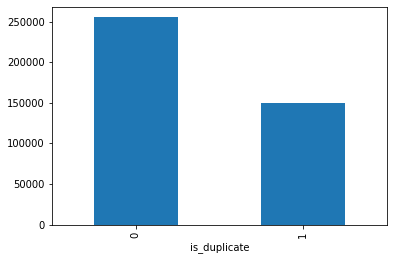

In [7]:
datafrm.groupby("is_duplicate")['id'].count().plot.bar()

**observation:**
* in above bar plot we can observe datapoints with (is_duplicate = 0) are more than the datapoints with (is_duplicate = 1)

In [8]:
#print percentage of question pairs with is_duplicate=0 and is_duplicate=1
print("percentage of question pairs with (is_duplicate=0):",(100 - round(datafrm['is_duplicate'].mean()*100)))
print("percentage of question pairs with (is_duplicate=1):",(round(datafrm['is_duplicate'].mean()*100)))

percentage of question pairs with (is_duplicate=0): 63.0
percentage of question pairs with (is_duplicate=1): 37.0


<h3> 3.2.2 Number of unique questions </h3>

In [9]:
qtn_ids = pd.Series(datafrm['qid1'].tolist() + datafrm['qid2'].tolist())   #combining all quastion ids in series in dataframe
unique_qstns = len(np.unique(qtn_ids))   #number of unique quation ids  
print('Number of unique questions based on ids:',unique_qstns)


# number quastions appeared more than one time
qsns_morethan_onetime = np.sum(qtn_ids.value_counts() > 1)
print("number questions appeared more than one time:",qsns_morethan_onetime,"percentage:", qsns_morethan_onetime/unique_qstns*100)

Number of unique questions based on ids: 537933
number questions appeared more than one time: 111780 percentage: 20.77953945937505


**bar plot to apper unique quastions and quations morethan_onetime**

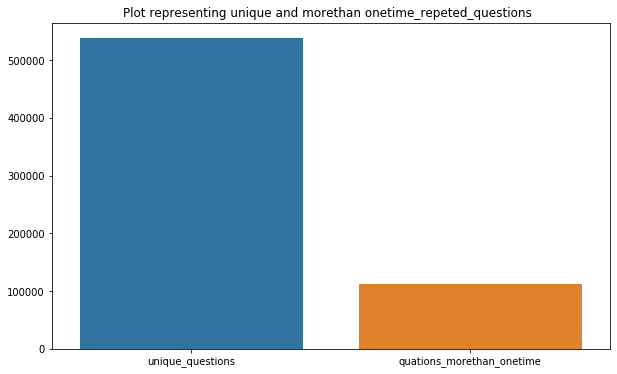

In [10]:
x = ["unique_questions" , "quations_morethan_onetime"]
y =  [unique_qstns , qsns_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and morethan onetime_repeted_questions  ")
sns.barplot(x,y)
plt.show()

in the above bart plot  unique quastions are above 5 lakh (excactly value 537933) and quations_morethan_onetime are 1 lakh (excactly value 111780)

<h3>3.2.3 Checking for Duplicates </h3>

**checking for any repeated pair of questions are there**

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = datafrm[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()  #group by qid1 and qid2 features, reset index will trure

print ("Number of duplicate questions",(pair_duplicates).shape[0] - datafrm.shape[0])  #pair of duplicates substituting with number of datapointsin data

Number of duplicate questions 0


there are no any duplicate questions

<h3> 3.2.4 Number of occurrences of each question </h3>

**histogram plot**

Maximum number of times a single question is repeated: 157



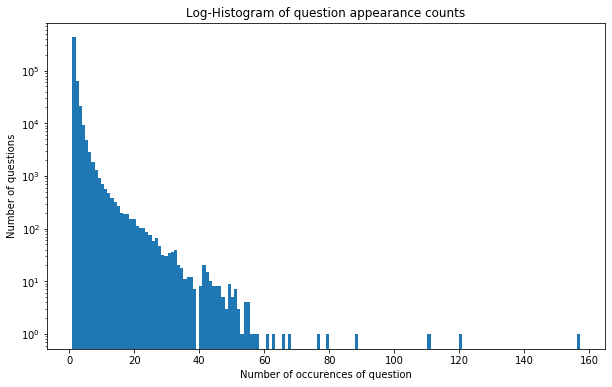

In [12]:
plt.figure(figsize=(10, 6))

plt.hist(qtn_ids.value_counts(),bins=160)   #qtn_ids implies all qustion ids(qid1+qid2)

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
plt.yscale('log', nonposy='clip')  #yscale values representing in log values


print ('Maximum number of times a single question is repeated: {}\n'.format(max(qtn_ids.value_counts()))) 

**observation:**
* x_axis implies number of occurences of questions 
* 1,00,000(1 lakh) questions are  occured only 1 time.

<h3> 3.2.5 Checking for NULL values </h3>

In [13]:
#Checking whether there are any rows with null values
nan_rows = datafrm[datafrm.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


* there are two NaN null values in question2

In [14]:
# Filling the null values with ' ' empy string
datafrm = datafrm.fillna('')
nan_rows = datafrm[datafrm.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


* now there are no any NaN null values

<h2>3.3 Basic Feature Extraction (Feature Engineering)  (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)---------->          no(of) comon words in qstn1 and qst2/(no(of) words in qstn1)+(no(of) words in qst2)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
#feature extraction without preprocessing our data
datafrm['freq_qid1'] = datafrm.groupby('qid1')['qid1'].transform('count')  #creating new feature:'freq_qid1': no of occurences(frequency)each quastion in qid1 
datafrm['freq_qid2'] = datafrm.groupby('qid2')['qid2'].transform('count')  #creating new feature:'freq_qid2': no of occurences(frequency)each quastion in qid2 
datafrm['q1len'] = datafrm['question1'].str.len()     #creating new feature:'q1len': lenght each question in question1
datafrm['q2len'] = datafrm['question2'].str.len()     ##creating new feature:'q2len': lenght each question in question2
datafrm['q1_n_words'] = datafrm['question1'].apply(lambda row: len(row.split(" ")))  #new feature:number words in question1
datafrm['q2_n_words'] = datafrm['question2'].apply(lambda row: len(row.split(" ")))  #new feature:number words in question2

def normalized_word_Common(row):                           #number of common words in qst1 and qstn2
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
datafrm['word_Common'] =datafrm.apply(normalized_word_Common, axis=1)   #new feature 'word_common':function applying on dataframe

def normalized_word_Total(row):                             #Total num of words in Question 1 + Total num of words in Question 2
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
datafrm['word_Total'] = datafrm.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):            # no(of) comon words in qstn1 and qst2/(no(of) words in qstn1)+(no(of) words in qst2)
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
datafrm['word_share'] = datafrm.apply(normalized_word_share, axis=1)

datafrm['freq_q1+q2'] = datafrm['freq_qid1']+datafrm['freq_qid2']  #sum total of frequency of qid1 and qid2 
datafrm['freq_q1-q2'] = abs(datafrm['freq_qid1']-datafrm['freq_qid2'])

datafrm.to_csv("df_fe_without_preprocessing_train.csv", index=False)   #converting our dataframe(feature extraction without preprocessed) into csv file 

In [16]:
#print dataframe shape and top 3 rows
print("shape of the dataframe:",datafrm.shape)
datafrm.head(2)

shape of the dataframe: (404290, 17)


id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

## 3.3.1 Analysis of some of the extracted features 

In [17]:
print ("Minimum length of the questions in question1 : " , min(datafrm['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(datafrm['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", datafrm[datafrm['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", datafrm[datafrm['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


### 3.3.1.1 Feature: word_share 

In [18]:
datafrm['word_share'].head(2)

0    0.434783
1    0.200000
Name: word_share, dtype: float64

#### Vilon plot and distribution plots

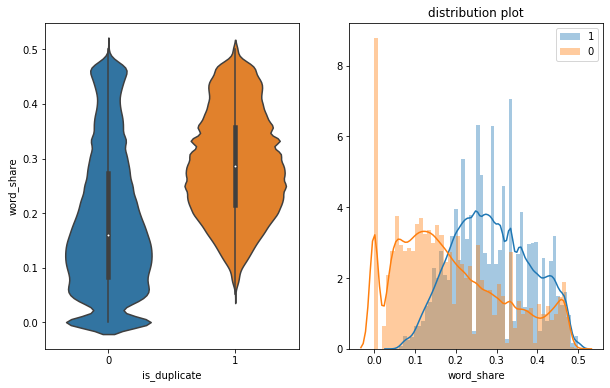

In [19]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)  #1st subplot 
#violinplot between is_duplicate(classlabel) and word_share feature
df_data  = datafrm[0:] #all datapoints
sns.violinplot(x = 'is_duplicate', y = 'word_share',data = df_data)  

#distribution plots
plt.subplot(1,2,2) #2nd subplot
sns.distplot(datafrm[datafrm['is_duplicate'] == 1.0]['word_share'][0:] , label = "1" )
sns.distplot(datafrm[datafrm['is_duplicate'] == 0.0]['word_share'][0:] , label = "0"  )
plt.title('distribution plot')
plt.legend()
plt.show()

**observation:**
* according to the above plot distribution plot  word_share feature values wich are is_duplicate=1 are more than the is_duplicate=0.
* there is some overlapp in between  words_shape points(is_dplicat=1 and 0)
* so it(word_share) is better to use our feature in dataset.

### 3.3.1.2 Feature:  word_Common 

word_Common = (Number of common unique words in Question 1 and Question 2)

In [20]:
datafrm['word_Common'].head(2)

0    10.0
1     4.0
Name: word_Common, dtype: float64

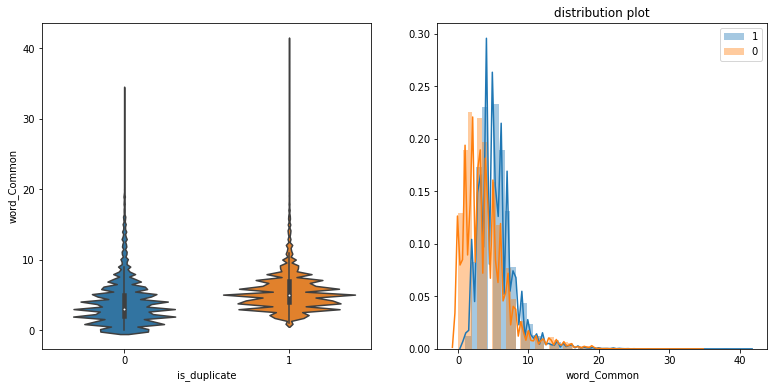

In [21]:
plt.figure(figsize=(13, 6))

plt.subplot(1,2,1)  #1st subplot 
#violinplot between is_duplicate(classlabel) and word_share feature
df_data  = datafrm[0:] #all datapoints
sns.violinplot(x = 'is_duplicate', y = 'word_Common',data = df_data)  

#distribution plots
plt.subplot(1,2,2) #2nd subplot
sns.distplot(datafrm[datafrm['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1" )
sns.distplot(datafrm[datafrm['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0"  )
plt.title('distribution plot')
plt.legend()
plt.show()

**observation:**
* according to the above plot distribution plot  word_common feature values wich are is_duplicate=1 are more than the is_duplicate=0.
* there is high overlapp in between  words_shape points(is_dplicat=1 and 0)
* so it(word_share) feature not gives much information.

### 3.3.1.2 Feature:  word_Total

Total num of words in Question 1 + Total num of words in Question 2

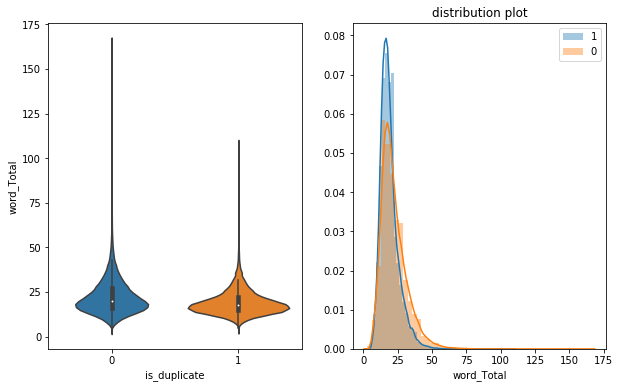

In [22]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)  #1st subplot 
#violinplot between is_duplicate(classlabel) and word_share feature
df_data  = datafrm[0:] #all datapoints
sns.violinplot(x = 'is_duplicate', y = 'word_Total',data = df_data)  

#distribution plots
plt.subplot(1,2,2) #2nd subplot
sns.distplot(datafrm[datafrm['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1" )
sns.distplot(datafrm[datafrm['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0"  )
plt.title('distribution plot')
plt.legend()
plt.show()

**observation:**
* there is completly overlapp in between  words_shape points(is_dplicat=1 and 0)
* so it(word_share) feature not gives much information.

### 3.3.1.4 Feature:  q1_n_words

Number of words in Question 1

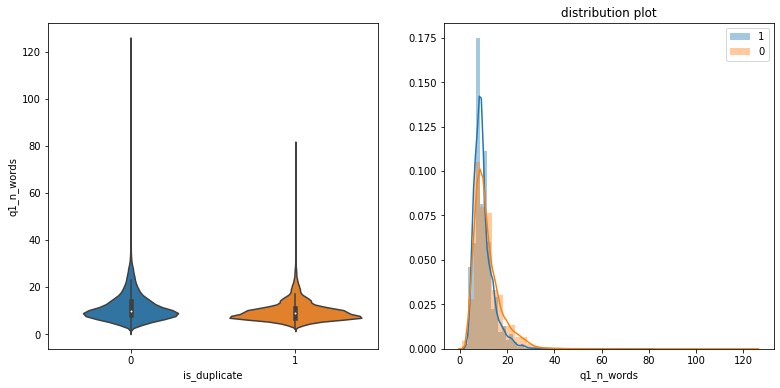

In [23]:
plt.figure(figsize=(13, 6))

plt.subplot(1,2,1)  #1st subplot 
#violinplot between is_duplicate(classlabel) and word_share feature
df_data  = datafrm[0:] #all datapoints
sns.violinplot(x = 'is_duplicate', y = 'q1_n_words',data = df_data)  

#distribution plots
plt.subplot(1,2,2) #2nd subplot
sns.distplot(datafrm[datafrm['is_duplicate'] == 1.0]['q1_n_words'][0:] , label = "1" )
sns.distplot(datafrm[datafrm['is_duplicate'] == 0.0]['q1_n_words'][0:] , label = "0"  )
plt.title('distribution plot')
plt.legend()
plt.show()

# <font color='green'>3.4 EDA: Advanced Feature Extraction.</font>

### 3.4.1 Preprocessing of Text

    - Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

 **Function to Compute and get the features : With 2 parameters of Question 1 and Question 2**

In [24]:
STOP_WORDS = stopwords.words("english") #all stopwards in english
len(STOP_WORDS)

179

In [25]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001

def preprocess(sntnc):
    sntnc = str(sntnc).lower()  
    #for each question in question1 and question2 features 
    # expand all contraction words
    #using python reguler expretion replace 000 with 'k' and 000000 with 'm'
    sntnc = sntnc.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    sntnc = re.sub(r"([0-9]+)000000", r"\1m", sntnc)
    sntnc = re.sub(r"([0-9]+)000", r"\1k", sntnc)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')  #
    
    if type(sntnc) == type(''):
        sntnc = re.sub(pattern, ' ', sntnc)
    
    
    if type(sntnc) == type(''):
        sntnc = porter.stem(sntnc)    #stemming of words 
        example1 = BeautifulSoup(sntnc)    #beautiful soup for remove all tags example html tags fron wcah questions
        sntnc = example1.get_text()
               
    
    return sntnc
    

## 3.4.2 Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS]) #removing stopwords from qst1
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS]) #removing stopwords from qst2
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])  #only stopwords from qst1
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))  #longestcommon substring
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [27]:
df2 = pd.read_csv("train.csv")


### for memory constraints i have seleected 100k datapoints

In [28]:
df1 = df2[0:100000]
df1.shape

(100000, 6)

In [29]:
#extrct our advance feature extracted features
new_df = extract_features(df1)   #extract_feature  above all functions applying on our dataset
new_df.head(3)

token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   
2  how can internet speed be increased by hacking...             0  0.399992   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   
2  0.333328  0.399992  0.249997  ...  0.285712           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   
2           4.0      12.0               63                63          43   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  
2                  47              0.166667  

[3 rows x 21 columns]

## 3.4.4 Analysis of extracted features 

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [30]:
df_duplicate = new_df[new_df['is_duplicate'] == 1]
dfp_nonduplicate = new_df[new_df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')  #saving into text file
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 74508
Number of data points in class 0 (non duplicate pairs) : 125492


In [31]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()    #open and read the textfile(duplicate pairs)
textn_w = open(path.join(d, 'train_n.txt')).read()

stopwords = set(STOPWORDS)
#adding some words into set of english stopwords and remove not no like
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")


print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 4021637
Total number of words in non duplicate pair questions : 8150007


Word Cloud for Duplicate Question pairs


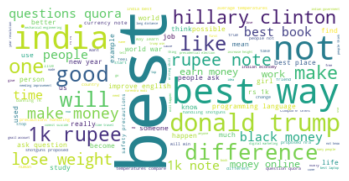

In [32]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

wrd_c1 = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wrd_c1.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wrd_c1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Clouds generated from non duplicate pair question's text 

Word Cloud for non-Duplicate Question pairs:


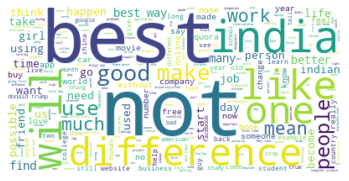

In [33]:
wrd_c2 = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wrd_c2.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wrd_c2, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

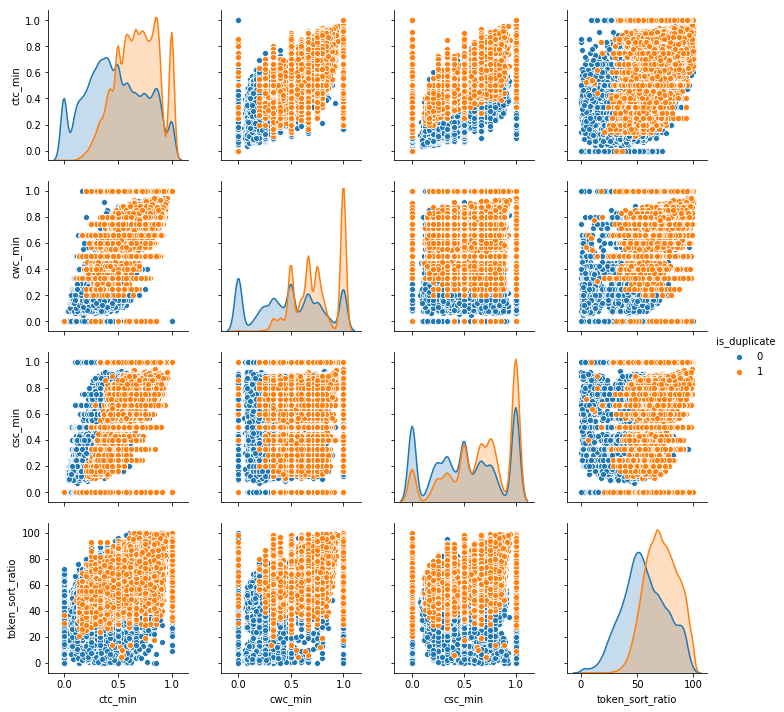

In [66]:
n = df.shape[0]
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

observation:
* in above pair plot duplicate and non duplicate all points are overlapped in all plots
* there is some better seperation in token_sort_ration (vs) ctc_min features

## 3.4.2 Visualization  TSNEE:

### note: never run tsnee one time, we have to try with  different perplexity and step values till get good shape

In [34]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
from sklearn.preprocessing import MinMaxScaler

df1 = new_df[0:30000]     #selecting 30k datapoints
#nomrmalizer applicable to all(13) features values
X = MinMaxScaler().fit_transform(df1[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df1['is_duplicate'].values   #class label

In [35]:
X.shape

(30000, 15)

**trying with default perplexity = 30 and default learning rate = 200**

In [89]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

model = TSNE(n_components = 2,init='random',method='barnes_hut',verbose=2, angle=0.5 ,random_state=1)

tsne_data = model.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.247s...
[t-SNE] Computed neighbors for 30000 samples in 9.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [90]:
print(tsne_data.shape)   #tsnee data
print(y.shape)   #label data

(30000, 2)
(30000,)


In [91]:
#append label

data1 = np.vstack((tsne_data.T, y)).T
print(data1.shape)


(30000, 3)


### creat dataframe

        dim1       dim2  label
0 -60.393085  -4.005689    0.0
1  -6.131124  13.793137    0.0
2   8.604098  36.061367    0.0
3 -51.956631 -23.617552    0.0
4 -19.407307  41.481701    0.0


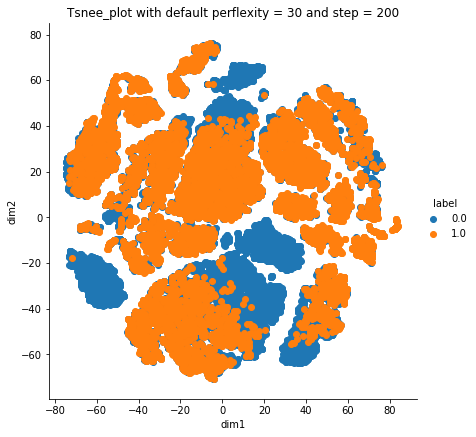

In [92]:
df = pd.DataFrame(data=data1, columns=('dim1','dim2','label'))
print(df.head())

### Tsnee plot using seaborn
sns.FacetGrid(df, hue='label', size = 6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title('Tsnee_plot with default perflexity = 30 and step = 200')
plt.show()

* 15 advnce extracted features are converted into 2-D 
* duplicate points and non dupicate points are  overlapped in 2-D space with default perflexity and step values

### Tsnee plot with perplexity=10, n_iter=1000

In [93]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

model = TSNE(n_components = 2,init='random',method='barnes_hut',perplexity=10, n_iter=1000,random_state=1)

tsne_data = model.fit_transform(X)
print("tsnee data shape:",tsne_data.shape)   #tsnee data
print("label data shape:",y.shape)   #label data

#append label

data1 = np.vstack((tsne_data.T, y)).T
print(data1.shape)


tsnee data shape: (30000, 2)
label data shape: (30000,)
(30000, 3)


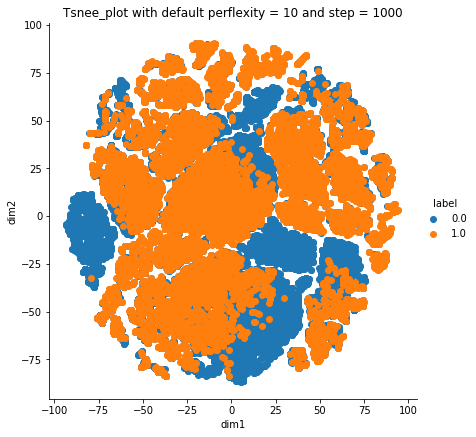

In [94]:
#creat dataframe
df = pd.DataFrame(data=data1, columns=('dim1','dim2','label'))

### Tsnee plot using seaborn
sns.FacetGrid(df, hue='label', size = 6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title('Tsnee_plot with default perflexity = 10 and step = 1000')
plt.show()

* 15 advnce extracted features are converted into 2-D 
*  duplicate points and non dupicate points are  high overlapped in 2-D space with  perflexity=10 and step values=1000

### Tsnee plot with perplexity=10, n_iter=5000

In [96]:
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

model = TSNE(n_components = 2,init='random',method='barnes_hut',perplexity=5, n_iter=2000,random_state=1)

tsne_data = model.fit_transform(X)
print("tsnee data shape:",tsne_data.shape)   #tsnee data
print("label data shape:",y.shape)   #label data

#append label
data1 = np.vstack((tsne_data.T, y)).T
print(data1.shape)

tsnee data shape: (30000, 2)
label data shape: (30000,)
(30000, 3)


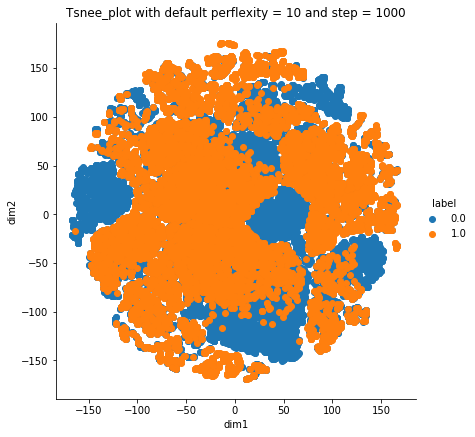

In [97]:
#creat dataframe
df = pd.DataFrame(data=data1, columns=('dim1','dim2','label'))

### Tsnee plot using seaborn
sns.FacetGrid(df, hue='label', size = 6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title('Tsnee_plot with default perflexity = 10 and step = 1000')
plt.show()

*  duplicate points and non dupicate points are  high overlapped in 2-D space with  perflexity=5 and step values=2000

### Tsnee with 3-dimensions

In [110]:
#https://plot.ly/python/3d-scatter-plots/
model = TSNE(n_components = 3,init='random',method='barnes_hut',perplexity=5, n_iter=500,random_state=1)

tsne_data = model.fit_transform(X)

trace1 = go.Scatter3d(
    x=tsne_data[:,0],
    y=tsne_data[:,1],
    z=tsne_data[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# 4.0 Splitting data

### split data into train, cross validation and test data

In [36]:
#our dataframe
print(new_df.shape)
new_df.head(1)


(100000, 21)


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   

                                           question2  is_duplicate  cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.99998   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  

[1 rows x 21 columns]

### drop empty values rows

#### remove from question 1

In [37]:
#https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe
new_df['question1'].replace('', np.nan, inplace=True)

In [38]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
new_df.dropna(subset=['question1'], inplace=True)

print(new_df.shape)
#df.dropna(subset=['Tenant'], inplace=True)


(99996, 21)


#### remove from question 1

In [39]:
new_df['question2'].replace('', np.nan, inplace=True)

In [40]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
new_df.dropna(subset=['question2'], inplace=True)

print(new_df.shape)

(99994, 21)


#### Seperating Label from data

In [41]:
#drop label data
y = new_df['is_duplicate'].values 
new_df.drop(['is_duplicate'], axis=1, inplace=True)   #drop the label data

In [42]:
print(new_df.shape)
new_df.head(1)


(99994, 20)


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   

                                           question2  cwc_min   cwc_max  \
0  what is the step by step guide to invest in sh...  0.99998  0.833319   

    csc_min   csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
0  0.999983  0.999983  0.916659  0.785709           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759

In [43]:
# splitting into train, crossvalidation and test data
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.33, stratify=y)  # split 33% data in test data and  67% in train data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  #split train data into train and cross_valiadation

In [44]:
#print shape of splitted data
print("data before feature vectorizing:")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

data before feature vectorizing:
(44886, 20) (44886,)
(22109, 20) (22109,)
(32999, 20) (32999,)


## 4.1 feature vectorization (TFIDF GLOVE)tfidf glove vectors

## 4.1.1 Converting  question1 in  Train,cv and test  data  text to TFIDF-GLOVE

**removing empty values from train questions**

In [45]:

tfidf = TfidfVectorizer(lowercase=False,min_df=10,ngram_range=(1,2), )
tfidf.fit(X_train['question1'])

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))   #questions1 

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

## I. Converting  'question1' in  Train data  text to TFIDF-GLOVE

In [46]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q1_train_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_train['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q1_train_ft.append(mean_vec1)
q1_train_feats = np.array(q1_train_ft)
print(q1_train_feats.shape)
print(len(q1_train_feats[2]))

100%|██████████| 44886/44886 [09:50<00:00, 76.06it/s]

(44886, 96)
96


## II. Converting  question1 in  cv data  text to TFIDF-GLOVE

In [47]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q1_cv_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_cv['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q1_cv_ft.append(mean_vec1)
q1_cv_feats = np.array(q1_cv_ft)
print(q1_cv_feats.shape)
print(q1_cv_feats[0])

100%|██████████| 22109/22109 [04:57<00:00, 74.21it/s]

(22109, 96)
[ 33.46687841  15.26750082 -26.53433013 -23.62397355 -20.83190632
   4.13099837  25.51761848  63.42703462   2.3845371   11.83372784
 -15.67241776  57.98628569 -57.365942    -3.55316168 -29.89763682
  -4.54305303  25.57304162 -24.54400826  56.37882352  27.85926986
   2.2901063   17.77108839   1.06264305  -4.01155946 -16.22128963
  24.03313994  14.4150995   18.43290544 -12.41974574  19.33414948
  -8.1162542  -12.51105464 -42.23259282   7.62586761   1.38442528
 -18.92157125 -36.7001586   25.28867908 -11.24726516  38.41390216
 -36.93090248  48.43826699 -22.00524896   0.33197963  34.36267698
 -27.22789335  -0.73763561 -15.9423492  -16.81266928 -33.11931181
 -12.32948446 -15.13265586  50.05252111 -20.17039311 -22.70685288
 -29.46822071 -28.22412014  33.55494785  13.22812068  24.13348436
  26.01081622 -17.80858831  11.42161867   2.60089207  33.57983685
  45.58080673 -11.52704477   2.25371242  -7.97045648   3.54604244
 -12.8682065   14.86882865 -22.57836175 -42.78002131   2.5318689

## III. Converting  question1 in  test data  text to TFIDF-GLOVE

In [48]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q1_test_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_test['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q1_test_ft.append(mean_vec1)
q1_test_feats = np.array(q1_test_ft)
print(q1_test_feats.shape)
print(len(q1_test_feats[0]))

100%|██████████| 32999/32999 [07:15<00:00, 75.86it/s]

(32999, 96)
96


# 4.1.2 Converting  'question2' in  Train,cv and test  data  text to TFIDF-GLOVE

In [49]:

tfidf2 = TfidfVectorizer(lowercase=False,min_df=10,ngram_range=(1,2), )
tfidf2.fit(X_train['question2'])

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf2.get_feature_names(), tfidf2.idf_))   #questions1 

### I. Converting  question2 in  Train data  text to TFIDF-GLOVE

In [50]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q2_train_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_train['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q2_train_ft.append(mean_vec1)
q2_train_feats = np.array(q2_train_ft)
print(q2_train_feats.shape)
print(len(q2_train_feats))

100%|██████████| 44886/44886 [10:07<00:00, 73.91it/s]


(44886, 96)
44886


## II. Converting  question2 in  cv data  text to TFIDF-GLOVE

In [51]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q2_cv_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_cv['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q2_cv_ft.append(mean_vec1)
q2_cv_feats = np.array(q2_cv_ft)
print(q2_cv_feats.shape)
print((q2_cv_feats[2]))

100%|██████████| 22109/22109 [04:58<00:00, 73.96it/s]


(22109, 96)
[  79.88231182   12.29724187  -18.69425076  -27.68252933  -31.22066522
   -0.26452661   47.37405728   -4.608289      4.02431494   71.41322088
   -9.28836906  -37.30680835  -47.21209024  -49.17002866  -14.52675366
  -11.95311996    6.18876496  -14.94365004   12.24291956   -9.7607674
  -48.21210241  -14.46204758   38.24733901   22.56219304   25.91325247
    4.80268192   18.59923816    6.40510941  -38.2096175    61.1144433
    4.21096873  -27.87569761 -107.84684563   26.87499833  -22.09920311
  -26.71557521  -33.43872595   89.56932592    8.69946647  -12.96517777
   -8.56032801   81.4506104     0.8835524    34.53742242   -0.97112429
  -13.13439435  -68.62872797  -17.84866858    1.93334436    5.05783546
    6.97086671  -31.20489407   10.69290471  -39.95215845   11.59141418
  -65.84820294   10.83426332  -10.07972423   -6.75508046   34.32663342
   14.10356975  -22.63701184   63.47147971  -40.38903153  -14.44521058
   53.29675961  -27.97708178   40.93165043    0.78721637   41.06643

### III. Converting  question2 in  test data  text to TFIDF-GLOVE

In [52]:
#install en_core_web_sm: command line : python3 -m spacy download en_core_web_lg
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy
import en_core_web_sm
nlp =  en_core_web_sm.load()

q2_test_ft = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(X_test['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    q2_test_ft.append(mean_vec1)
q2_test_feats = np.array(q2_test_ft)
print(q2_test_feats.shape)


100%|██████████| 32999/32999 [07:22<00:00, 68.51it/s]

(32999, 96)


### concatinating all numerical features according to train, cv and test data

In [53]:
a_train = pd.concat([X_train['id'],X_train['qid1'],X_train['qid2'],X_train['cwc_min'], X_train['cwc_max'],  X_train['csc_min'], X_train['csc_max'], X_train['ctc_min'],X_train['ctc_max'], X_train['last_word_eq'],  X_train['first_word_eq'] ,X_train['abs_len_diff'] ,X_train['mean_len'],  X_train['token_set_ratio'],X_train['token_sort_ratio'], X_train['fuzz_ratio'], X_train['fuzz_partial_ratio'],X_train['longest_substr_ratio']], axis=1)
b_cv = pd.concat([X_cv['id'],        X_cv['qid1'],    X_cv['qid2']  ,X_cv['cwc_min'],    X_cv['cwc_max'],       X_cv['csc_min'] ,   X_cv['csc_max'],   X_cv['ctc_min'] ,  X_cv['ctc_max'], X_cv['last_word_eq'],        X_cv['first_word_eq']   ,X_cv['abs_len_diff']   ,  X_cv['mean_len']  ,   X_cv['token_set_ratio']  , X_cv['token_sort_ratio'],     X_cv['fuzz_ratio'] ,  X_cv['fuzz_partial_ratio'] ,  X_cv['longest_substr_ratio']],axis=1)
c_test = pd.concat([X_test['id'],  X_test['qid1'],  X_test['qid2'], X_test['cwc_min'],  X_test['cwc_max'],    X_test['csc_min'],X_test['csc_max'],   X_test['ctc_min'], X_test['ctc_max'], X_test['last_word_eq'],    X_test['first_word_eq']  , X_test['abs_len_diff'] , X_test['mean_len'],  X_test['token_set_ratio'],  X_test['token_sort_ratio'],  X_test['fuzz_ratio'],  X_test['fuzz_partial_ratio'], X_test['longest_substr_ratio']],axis=1)

In [54]:
print("shape of advance extracted numerical train features:", a_train.shape)
a_train.head(2)

shape of advance extracted numerical train features: (44886, 18)


id   qid1    qid2   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
23213  23213  43513   43514  0.999975  0.999975  0.999967  0.749981  0.999986   
78633  78633  49955  134041  0.666644  0.499988  0.000000  0.000000  0.333328   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
23213  0.874989           1.0            0.0           1.0       7.5   
78633  0.222220           1.0            0.0           3.0       7.5   

       token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
23213              100                95          95                 100   
78633               52                49          58                  67   

       longest_substr_ratio  
23213              0.976190  
78633              0.393939

## merge vectorized train,cv and test question1 and question2 features corresponding to numerical features

In [55]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
import numpy as np
from scipy import sparse

X_tra = np.hstack((q1_train_feats,q2_train_feats, a_train))
X_cv =  np.hstack((q1_cv_feats,q2_cv_feats, b_cv))
X_tes = np.hstack((q1_test_feats,q2_test_feats,c_test))

print("*"*60)
print("Final Data after vectorization:")
print(X_tra.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_tes.shape, y_test.shape)

************************************************************
Final Data after vectorization:
(44886, 210) (44886,)
(22109, 210) (22109,)
(32999, 210) (32999,)


In [56]:
#checking the dataframe
a11 = pd.DataFrame(X_tra)
a11.head((3))

0          1          2          3          4          5    \
0  26.956176 -43.373905 -12.246819 -44.305911 -19.833930   4.139341   
1  81.094973 -45.243632  35.606846 -55.034807 -71.340558  -5.591494   
2  54.243000 -26.656049  -1.048881 -83.858774 -42.409462  16.690645   

         6          7          8          9    ...       200  201  202  203  \
0  73.993428 -83.162734  17.540329  32.827738  ...  0.874989  1.0  0.0  1.0   
1   3.137218  -5.898193  26.508001  65.318813  ...  0.222220  1.0  0.0  3.0   
2  19.592532  14.873506  -5.293114  34.200445  ...  0.874989  1.0  1.0  1.0   

   204    205   206   207    208       209  
0  7.5  100.0  95.0  95.0  100.0  0.976190  
1  7.5   52.0  49.0  58.0   67.0  0.393939  
2  7.5  100.0  90.0  90.0   86.0  0.724138  

[3 rows x 210 columns]

## Confusion matrix

## Confusion matrix , precesion matrix and recall matrix

In [57]:
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 4.4 Building a random model (Finding worst-case log-loss) 

#### 1. Random model to check log_loss value for our dumb model
#### 2. after fing the log loss value(0,to logloss value) after then out base models logg loss should be lie in between (0 to random model log loss value)

In [58]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274339437686584 Class 1:  0.37256605623134165
---------- Distribution of output variable in train data ----------
Class 0:  0.37255674414376194 Class 1:  0.37255674414376194


Log loss on Test Data using Random Model 0.888832903154112


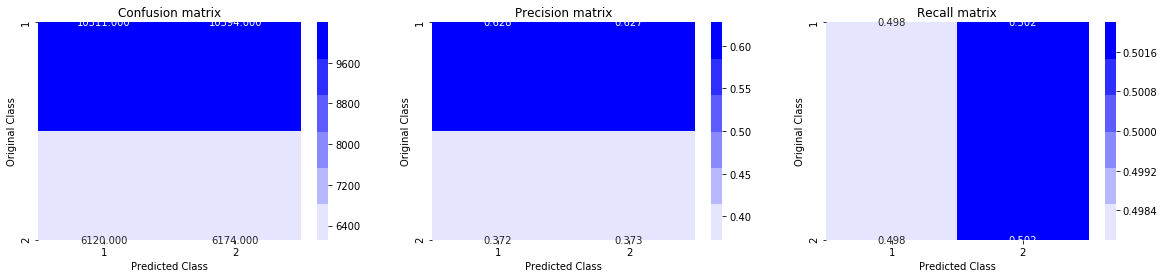

In [59]:
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)


**Observation:**

* in random model(dumb model)  log_loss value = 0.88
* so our any base model log loss value should lie in between 0 to 0.88
    
* in the above confusion matrix we can observae tru positive points are 6066, true negetive points are 10326
* in the precion matrix precion = true positive/actual result  for tp = 0.36, and tn = 0.624
* in  recall matrix  = true positive/predicted result for tp = 0.49 and tn = 0.43

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>


### Hyper parameter tuning using for loop

* here we are using calibrated classifier to find exact probality score of y values
* we have selected sigmoid method insted of isotonic method

For values of alpha =  1e-05 The log loss is: 0.6603024158823461
For values of alpha =  0.0001 The log loss is: 0.6603024158823461
For values of alpha =  0.001 The log loss is: 0.6603024158823461
For values of alpha =  0.01 The log loss is: 0.6603024158823461
For values of alpha =  0.1 The log loss is: 0.6603024158823461
For values of alpha =  1 The log loss is: 0.5960629500087591
For values of alpha =  10 The log loss is: 0.5825756435584201


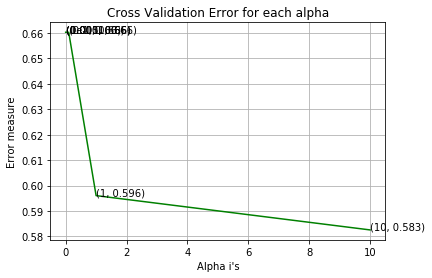

In [60]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)  # l2 regulerization
    clf.fit(X_tra, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")   #calibrated classifier
    sig_clf.fit(X_tra, y_train)
    predict_y = sig_clf.predict_proba(X_tes)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


* note: we have to select log loss values is near 0 value
* according to the above plot we can choose best alpha = 10 (wich contain minimum log loss value = 0.58)


### PLot confusion matrix, precision matrix and recall matrix

In [65]:
best_alpha = 10

For values of best alpha =  10 The train log loss is: 0.5787410500055556
For values of best alpha =  10 The test log loss is: 0.5825756435584201
Total number of data points : 32999


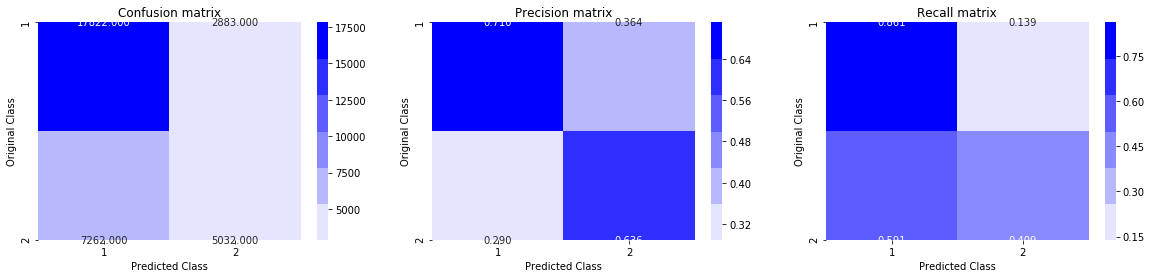

In [68]:
#best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=10, penalty='l2', loss='log', random_state=42)  #selecting alpha 
clf.fit(X_tra, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tra, y_train)

predict_y = sig_clf.predict_proba(X_tra)   #probablity yi's predict on train data
print('For values of best alpha = ',10, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_tes)   #probablity yi's predict on test data
print('For values of best alpha = ', 10, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**observation:**
* we can observe  (true positive  and true negetive points) of  confusion matrix, precision matrix and recall matrix  

##  4.5 Linear SVM with hyperparameter tuning 

* SVM is a SGD classifier with loss = 'hinge'
#### * sklearn.smv.SVC is more computational requires it takes more time for low RAM systems to compute linear svm
#### * so there is one other alternative way to perform linear svm by using SGDclassifier(loss='hinge') it work as same as sklearn.svm.SVC
#### * hinge loss it is  soft svm formulation minimizing the loss function
#### * but we couldn't peroform RBF kernalizetion in this sgdclassifier(loss='hinge')
#### *we can perform any kernal(polynomial, RBF,sigmoidlinear..etc)
####  * after using SGDclassifier if we want probablities values then we can use CalibratedClassifierCV it give probablity score of each output label

For values of alpha =  1e-05 The log loss is: 0.6603024158823461
For values of alpha =  0.0001 The log loss is: 0.6603024158823461
For values of alpha =  0.001 The log loss is: 0.6603024158823461
For values of alpha =  0.01 The log loss is: 0.6603024158823461
For values of alpha =  0.1 The log loss is: 0.6603024158823461
For values of alpha =  1 The log loss is: 0.5638332813130054
For values of alpha =  10 The log loss is: 0.6007253189433972
For values of alpha =  100 The log loss is: 0.6043286514694362


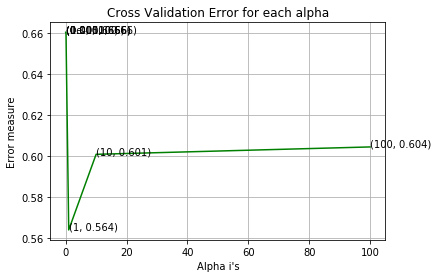

For values of best alpha =  1 The train log loss is: 0.560851045269547
For values of best alpha =  1 The test log loss is: 0.5638332813130054
Total number of data points : 32999


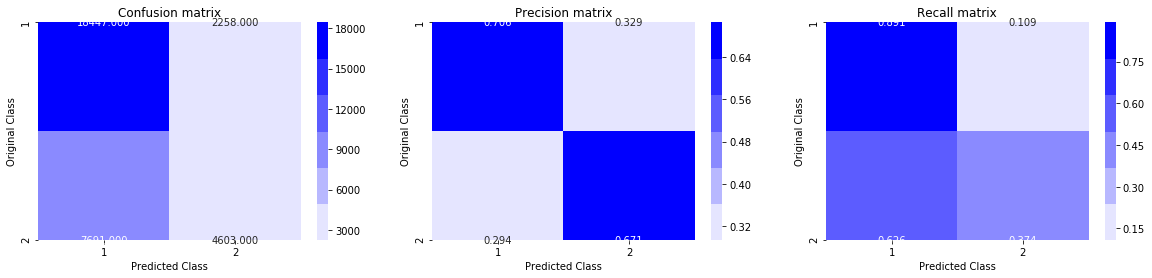

In [69]:
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=0)
    clf.fit(X_tra, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")  #for probablity yi's
    sig_clf.fit(X_tra, y_train)
    predict_y = sig_clf.predict_proba(X_tes)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
    
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=0)
clf.fit(X_tra, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tra, y_train)

predict_y = sig_clf.predict_proba(X_tra)   #predict on train data
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_tes)  #predict on test data
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**observation:**
* best alpha = 1 with logloss = 0.56
* we can observe  (true positive  and true negetive points) of  confusion matrix, precision matrix and recall matrix 
* these are slightly better than tha Logistic regeression


## 4.6 XGBoost 

In [70]:
### without Hyperparameter Tunning

In [71]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_tra, label=y_train)
d_test = xgb.DMatrix(X_tes, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tra,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.686755	valid-logloss:0.686791
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.634466	valid-logloss:0.634997
[20]	train-logloss:0.597436	valid-logloss:0.59841
[30]	train-logloss:0.569479	valid-logloss:0.570928
[40]	train-logloss:0.548481	valid-logloss:0.550395
[50]	train-logloss:0.531484	valid-logloss:0.533878
[60]	train-logloss:0.51756	valid-logloss:0.520503
[70]	train-logloss:0.506267	valid-logloss:0.509733
[80]	train-logloss:0.497162	valid-logloss:0.501038
[90]	train-logloss:0.488827	valid-logloss:0.493254
[100]	train-logloss:0.482275	valid-logloss:0.487162
[110]	train-logloss:0.476375	valid-logloss:0.48178
[120]	train-logloss:0.471885	valid-logloss:0.477696
[130]	train-logloss:0.467191	valid-logloss:0.473498
[140]	train-logloss:0.462976	valid-logloss:0.469803
[150]	train-logloss:0.459836	valid-logloss:0.467145
[160]	train-logloss:0.456144	va

Total number of data points : 32999


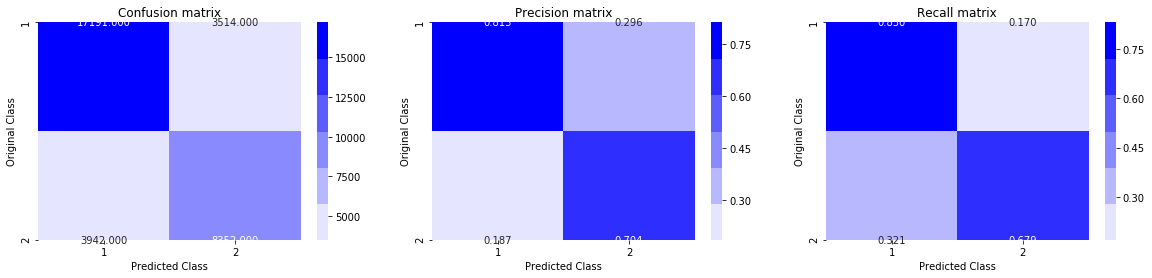

In [72]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**observation:**
* best test logloss = 0.43  (decreses if campare with svm)
* so XGbosst better than tha svm
* we can observe  (true positive  and true negetive points) of  confusion matrix, precision matrix and recall matrix 
* these are slightly better than tha Logistic regeression there is high TPR and TNR.


### SUMMARY:
#### So eventually we can say xg boost  test log loss is 0.42 and true positive points and True negetive  well predicted, 

#### XGBOOST classifier better than with logistic regeression and linear SVM

# 5.Assignment

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


### Our dataframe

In [90]:
print(new_df.shape)
new_df.head(1)


(99994, 20)


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   

                                           question2  cwc_min   cwc_max  \
0  what is the step by step guide to invest in sh...  0.99998  0.833319   

    csc_min   csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
0  0.999983  0.999983  0.916659  0.785709           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759

In [91]:
#class label is_duplicate
y

array([0, 0, 0, ..., 1, 0, 0])

### Splitting data

In [92]:
# splitting into train, crossvalidation and test data
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score, log_loss

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.33, stratify=y)  # split 33% data in test data and  67% in train data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  #split train data into train and cross_valiadation

In [93]:
#print shape of splitted data
print("data before feature vectorizing:")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

data before feature vectorizing:
(44886, 20) (44886,)
(22109, 20) (22109,)
(32999, 20) (32999,)


**observation**
* there are 44886 datapoints in train data.
* 22109 datapoints in cross validation data.
* 32999 datapoints in test data.

## 5.1 feature vectorization (TFIDF)

## 5.1.1 converting the question1 to vectors(TFIDF)

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer2.fit(X_train['question1'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_qst1_tfidf = vectorizer2.transform(X_train['question1'].values)
X_cv_qst1_tfidf = vectorizer2.transform(X_cv['question1'].values)
X_test_qst1_tfidf = vectorizer2.transform(X_test['question1'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_qst1_tfidf.shape, y_train.shape)
print(X_cv_qst1_tfidf.shape, y_cv.shape)
print(X_test_qst1_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(44886, 8101) (44886,)
(22109, 8101) (22109,)
(32999, 8101) (32999,)


## 5.1.2 converting the question2 to vectors(TFIDF)

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer2.fit(X_train['question2'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_qst2_tfidf = vectorizer2.transform(X_train['question2'].values)
X_cv_qst2_tfidf = vectorizer2.transform(X_cv['question2'].values)
X_test_qst2_tfidf = vectorizer2.transform(X_test['question2'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_qst2_tfidf.shape, y_train.shape)
print(X_cv_qst2_tfidf.shape, y_cv.shape)
print(X_test_qst2_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(44886, 8382) (44886,)
(22109, 8382) (22109,)
(32999, 8382) (32999,)


### concatinating all numerical features according to train, cv and test data

In [96]:
a_train = pd.concat([X_train['id'],X_train['qid1'],X_train['qid2'],X_train['cwc_min'], X_train['cwc_max'],  X_train['csc_min'], X_train['csc_max'], X_train['ctc_min'],X_train['ctc_max'], X_train['last_word_eq'],  X_train['first_word_eq'] ,X_train['abs_len_diff'] ,X_train['mean_len'],  X_train['token_set_ratio'],X_train['token_sort_ratio'], X_train['fuzz_ratio'], X_train['fuzz_partial_ratio'],X_train['longest_substr_ratio']], axis=1)
b_cv = pd.concat([X_cv['id'],        X_cv['qid1'],    X_cv['qid2']  ,X_cv['cwc_min'],    X_cv['cwc_max'],       X_cv['csc_min'] ,   X_cv['csc_max'],   X_cv['ctc_min'] ,  X_cv['ctc_max'], X_cv['last_word_eq'],        X_cv['first_word_eq']   ,X_cv['abs_len_diff']   ,  X_cv['mean_len']  ,   X_cv['token_set_ratio']  , X_cv['token_sort_ratio'],     X_cv['fuzz_ratio'] ,  X_cv['fuzz_partial_ratio'] ,  X_cv['longest_substr_ratio']],axis=1)
c_test = pd.concat([X_test['id'],  X_test['qid1'],  X_test['qid2'], X_test['cwc_min'],  X_test['cwc_max'],    X_test['csc_min'],X_test['csc_max'],   X_test['ctc_min'], X_test['ctc_max'], X_test['last_word_eq'],    X_test['first_word_eq']  , X_test['abs_len_diff'] , X_test['mean_len'],  X_test['token_set_ratio'],  X_test['token_sort_ratio'],  X_test['fuzz_ratio'],  X_test['fuzz_partial_ratio'], X_test['longest_substr_ratio']],axis=1)

In [97]:
print("shape of advance extracted numerical train features:", a_train.shape)
a_train.head(2)

shape of advance extracted numerical train features: (44886, 18)


id    qid1    qid2   cwc_min   cwc_max   csc_min   csc_max  \
58670  58670  102889  102890  0.699993  0.538457  0.714276  0.624992   
38546  38546   69986   69987  0.000000  0.000000  0.000000  0.000000   

        ctc_min   ctc_max  last_word_eq  first_word_eq  abs_len_diff  \
58670  0.521737  0.461537           0.0            0.0           3.0   
38546  0.000000  0.000000           0.0            0.0           5.0   

       mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
58670      24.5               83                71          27   
38546       8.5               49                48          35   

       fuzz_partial_ratio  longest_substr_ratio  
58670                  40              0.205882  
38546                  41              0.178571

### merge tfidf vectorized train,cv and test question1 and question2 features corresponding to numerical features

In [98]:
#https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack

X_tr1 = hstack((X_train_qst1_tfidf,X_train_qst2_tfidf,np.array(a_train))).tocsr()
X_cv1 = hstack((X_cv_qst1_tfidf,X_cv_qst2_tfidf, np.array(b_cv))).tocsr()
X_te1 = hstack((X_test_qst1_tfidf,X_test_qst2_tfidf,np.array(c_test))).tocsr()

print("*"*60)
print("Final Data after vectorization:")
print(X_tr1.shape, y_train.shape)
print(X_cv1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)


************************************************************
Final Data after vectorization:
(44886, 16501) (44886,)
(22109, 16501) (22109,)
(32999, 16501) (32999,)


## 5.2 Logistic Regression with hyperparameter tuning

### Hyper parameter tuning using for loop

* here we are using calibrated classifier to find exact probality score of y values
* we have selected sigmoid method insted of isotonic method

For values of alpha =  1e-05 The log loss is: 0.6603024158823462
For values of alpha =  0.0001 The log loss is: 0.6603024158823462
For values of alpha =  0.001 The log loss is: 0.6603024158823462
For values of alpha =  0.01 The log loss is: 0.6603024158823462
For values of alpha =  0.1 The log loss is: 0.6603024158823462
For values of alpha =  1 The log loss is: 0.6387448322537475
For values of alpha =  10 The log loss is: 0.621406458451492


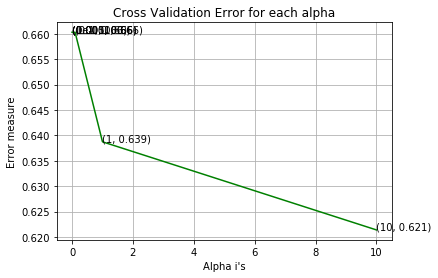

In [123]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)  # l2 regulerization
    clf.fit(X_tr1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")   #calibrated classifier
    sig_clf.fit(X_tr1, y_train)
    predict_y = sig_clf.predict_proba(X_te1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


**observation:**
* we can choose best alpha value = 1, beacause of it contains low loglooss value = 0.61

### Plot confusion matrix, precision matrix and recall matrix

In [160]:
best_alpha = 1

For values of best alpha =  0.0001 The train log loss is: 0.6145291430014849
For values of best alpha =  0.0001 The test log loss is: 0.6169292590692914
Total number of data points : 32999


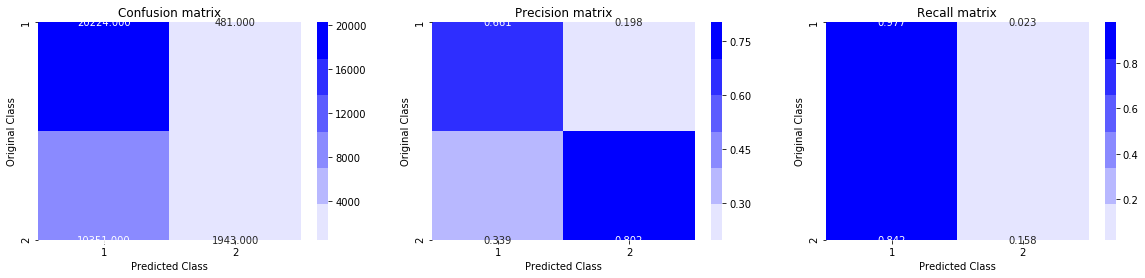

In [161]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)  #selecting alpha 
clf.fit(X_tr1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr1, y_train)

predict_y = sig_clf.predict_proba(X_tr1)   #probablity yi's predict on train data
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te1)   #probablity yi's predict on test data
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**observation:**
* we can observe  (true positive  and true negetive points) of  confusion matrix, precision matrix and recall matrix


##  5.3 Linear SVM with hyperparameter tuning 

* SVM is a SGD classifier with loss = 'hinge'
#### * sklearn.smv.SVC is more computational requires it takes more time for low RAM systems to compute linear svm
#### * so there is one other alternative way to perform linear svm by using SGDclassifier(loss='hinge') it work as same as sklearn.svm.SVC
#### * hinge loss it is  soft svm formulation minimizing the loss function
#### * but we couldn't peroform RBF kernalizetion in this sgdclassifier(loss='hinge')
#### *we can perform any kernal(polynomial, RBF,sigmoidlinear..etc)
####  * after using SGDclassifier if we want probablities values then we can use CalibratedClassifierCV it give probablity score of each output label

For values of alpha =  1e-05 The log loss is: 0.6603024158823461
For values of alpha =  0.0001 The log loss is: 0.6603024158823461
For values of alpha =  0.001 The log loss is: 0.6603024158823461
For values of alpha =  0.01 The log loss is: 0.6603024158823461
For values of alpha =  0.1 The log loss is: 0.6603024158823461
For values of alpha =  1 The log loss is: 0.6352683633535388
For values of alpha =  10 The log loss is: 0.6381239935632447
For values of alpha =  100 The log loss is: 0.6347198945703019


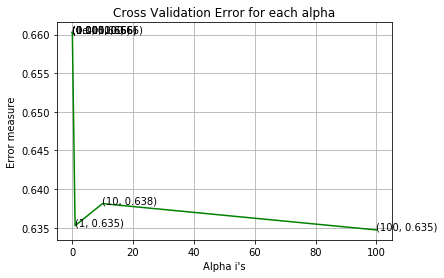

In [162]:
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=0)
    clf.fit(X_tr1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")  #for probablity yi's
    sig_clf.fit(X_tr1, y_train)
    predict_y = sig_clf.predict_proba(X_te1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
    
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.grid()
plt.show()


**observation:**
* we can choose best alpha value = 10, beacause of it contains low loglooss value = 0.63

### Plot confusion matrix, precision matrix and recall matrix

In [163]:
best_alpha = 10

For values of best alpha =  100 The train log loss is: 0.6323052338442404
For values of best alpha =  100 The test log loss is: 0.6347198945703019
Total number of data points : 32999


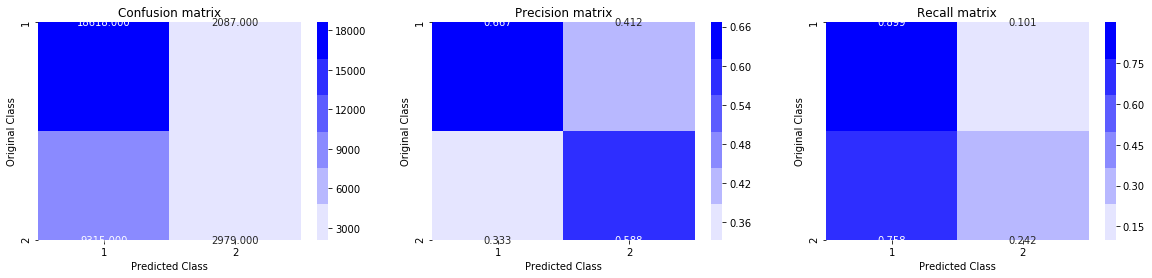

In [165]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=0)
clf.fit(X_tr1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr1, y_train)

predict_y = sig_clf.predict_proba(X_tr1)   #predict on train data
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te1)  #predict on test data
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**observation:**
* we can observe  (true positive  and true negetive points) of  confusion matrix, precision matrix and recall matrix


# 5.4 XGBoost 

### With Hyperparameter Tunning with random search

#### 1. we should use sklearn wrapper API for training our model with Randomizersearchcv 
####  and we have to use xgbclassifier to train your model

**hyper parametertunning max_depth using Rndomseachcv** 

In [132]:
# ref:   https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
#https://www.google.com/search?client=ubuntu&channel=fs&q=from+sklearn.model_selection+import+randomsearchcv&ie=utf-8&oe=utf-8
# https://stackoverflow.com/questions/36089083/how-to-use-log-loss-in-sklearn-grid-search

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV



parameters1 = {'min_child_weight': [1,3, 5,7, 10],'max_depth': [3, 4, 5,10,20]}

xgb1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300,booster='gbtree', objective='binary:logistic',silent=True,)

random_search = RandomizedSearchCV(xgb1, param_distributions=parameters1,  scoring='roc_auc',  cv=3,  random_state=42, n_jobs=-1)

random_search.fit(X_tr1, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=300,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
          

In [134]:
random_search.best_params_

{'min_child_weight': 3, 'max_depth': 10}

**observation:**
    * we can choose  the best max_depth = 10

In [137]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['min_child_weight'] = 3     # tuned parameter 
params['max_depth'] = 10          #tuned parameter

d_train = xgb.DMatrix(X_tr1, label=y_train)
d_test = xgb.DMatrix(X_te1, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tr1,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684464	valid-logloss:0.685118
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.612273	valid-logloss:0.619611
[20]	train-logloss:0.559316	valid-logloss:0.572894
[30]	train-logloss:0.519089	valid-logloss:0.538462
[40]	train-logloss:0.487934	valid-logloss:0.512437
[50]	train-logloss:0.463795	valid-logloss:0.491841
[60]	train-logloss:0.445067	valid-logloss:0.47648
[70]	train-logloss:0.429523	valid-logloss:0.464161
[80]	train-logloss:0.415791	valid-logloss:0.453889
[90]	train-logloss:0.404986	valid-logloss:0.445826
[100]	train-logloss:0.395532	valid-logloss:0.439097
[110]	train-logloss:0.387384	valid-logloss:0.43357
[120]	train-logloss:0.380527	valid-logloss:0.428916
[130]	train-logloss:0.374291	valid-logloss:0.424796
[140]	train-logloss:0.369027	valid-logloss:0.421587
[150]	train-logloss:0.364857	valid-logloss:0.419042
[160]	train-logloss:0.360947	v

**observation:** 
   * if we compare our  XGBOOST(without hyper parameter tunning) train and test logloss with XGBOOST (hyper parameter traing) training and test logloss then we can observe  the train and test log loss will improved(means decreased) for XGboost with hyper parameter tunning XGboost model
    

Total number of data points : 32999


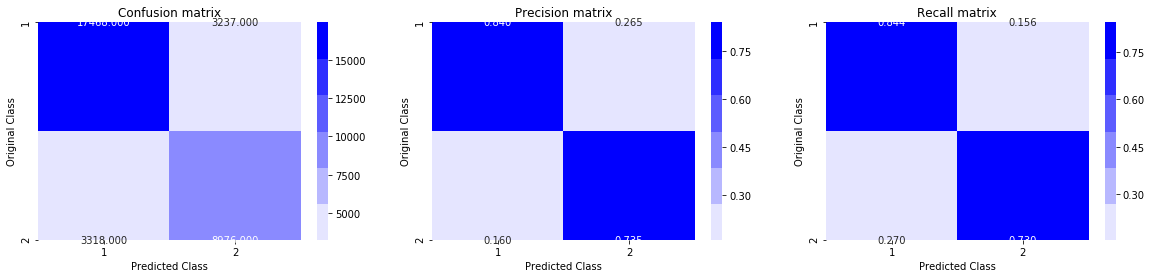

In [142]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

* if we observe  confusion matrix, precision matrix and recall matrix  for xgboost(without hyperparameter tuning and and xgboost(with hyper parameter tunning)) that diagonal values of True positive points and true negetive points are increased

# Summary(Conclusion):

* we did Feature Extraction And Advance Feature extraction on our data using Question and Question2 Basic Features.
* then we also did some Exploratory Data Analysis of some extracted features.
* then we have performed preprocessed  and vectorization on feature1 and feature2
* we have applied Rndome model then we got log loss = 0.88(we can assume this Random model is a dumb modem because this fitted randomly data)after we got logloss for dumb model the log loss value for any base model should have lessthan dumb model log loss value
* we have performed some base_learners(base_models)on our data and performed logloss metric on each of them
* and we also performed confusion matrix on each base model, according to the confusion matrix we can easily observe how much our data is correctly classified


# Summary in Tabular form

### all results summarized in the tabular form

**this Tabular form all  values  after Tfidf vectorization of the text data features question1 and question2**

In [84]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
a = PrettyTable()
a.field_names = ["model","Train_Logloss","Test_logloss",]

a.add_row(["*******************after","__TFIDF-GLOVE__","vectorization***********"])
a.add_row(["1. Random_model", "-", 0.88])
a.add_row(["2. Logistic_regression",0.57,0.58])

a.add_row(["3.Linear_SVM", 0.56,0.56])
a.add_row(["4.XGboost(without hyptunning)",0.43,0.43 ])

a.add_row(["************************","***************","**********************"])
a.add_row(["******************after","____TF-IDF____","vectorization***********"])
a.add_row(["1.Logistic_regression",0.61,0.61 ])

a.add_row(["2.Linear_SVM", 0.63,0.63])
a.add_row(["3.XGboost(with hyptunning)",0.39,0.39 ])
print(a)

+-------------------------------+-----------------+--------------------------+
|             model             |  Train_Logloss  |       Test_logloss       |
+-------------------------------+-----------------+--------------------------+
|    *******************after   | __TFIDF-GLOVE__ | vectorization*********** |
|        1. Random_model        |        -        |           0.88           |
|     2. Logistic_regression    |       0.57      |           0.58           |
|          3.Linear_SVM         |       0.56      |           0.56           |
| 4.XGboost(without hyptunning) |       0.43      |           0.43           |
|    ************************   | *************** |  **********************  |
|    ******************after    |  ____TF-IDF____ | vectorization*********** |
|     1.Logistic_regression     |       0.61      |           0.61           |
|          2.Linear_SVM         |       0.63      |           0.63           |
|   3.XGboost(with hyptunning)  |       0.39      | 